Copyright (c) Microsoft Corporation. All rights reserved.  

Licensed under the MIT License.

Based on [Azure ML Notebooks](https://github.com/Azure/MachineLearningNotebooks/tree/master/how-to-use-azureml/training-with-deep-learning/train-hyperparameter-tune-deploy-with-tensorflow)

# Custom Deep Learning: Shelf Compliance Classification Model

In this tutorial, you will train, hyperparameter tune, and deploy a PyTorch model using the Azure Machine Learning (Azure ML) Python SDK.

This tutorial will train an image classification model using transfer learning, based on PyTorch's [Transfer Learning tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html). The model is trained to classify ants and bees by first using a pretrained ResNet18 model that has been trained on the [ImageNet](http://image-net.org/index) dataset.

## Prerequisites
* Go through the [Configuration](../../../configuration.ipynb) notebook to install the Azure Machine Learning Python SDK and create an Azure ML `Workspace`

In [1]:
# Check core SDK version number
import azureml.core

print("SDK version:", azureml.core.VERSION)

SDK version: 1.0.17


## Diagnostics
Opt-in diagnostics for better experience, quality, and security of future releases.

In [2]:
from azureml.telemetry import set_diagnostics_collection

set_diagnostics_collection(send_diagnostics=True)

Turning diagnostics collection on. 


## Initialize workspace
Initialize a [Workspace](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#workspace) object from the existing workspace you created in the Prerequisites step. `Workspace.from_config()` creates a workspace object from the details stored in `config.json`.

In [3]:
from azureml.core.workspace import Workspace

ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep='\n')

Found the config file in: /home/nbuser/library/config.json
Workspace name: AML_test
Azure region: eastus
Subscription id: 60dcdfe6-7fbc-4c33-96f9-ef1e832d16a3
Resource group: AML_test_rg


## Create or Attach existing AmlCompute
You will need to create a [compute target](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#compute-target) for training your model. In this tutorial, we use Azure ML managed compute ([AmlCompute](https://docs.microsoft.com/azure/machine-learning/service/how-to-set-up-training-targets#amlcompute)) for our remote training compute resource.

**Creation of AmlCompute takes approximately 5 minutes.** If the AmlCompute with that name is already in your workspace, this code will skip the creation process.

As with other Azure services, there are limits on certain resources (e.g. AmlCompute) associated with the Azure Machine Learning service. Please read [this article](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-manage-quotas) on the default limits and how to request more quota.

In [4]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# choose a name for your cluster
cluster_name = "gpucluster"

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target.')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_NC6', 
                                                           max_nodes=4)

    # create the cluster
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

    compute_target.wait_for_completion(show_output=True)

# use get_status() to get a detailed status for the current cluster. 
print(compute_target.get_status().serialize())

Found existing compute target.
{'allocationState': 'Steady', 'allocationStateTransitionTime': '2019-03-11T16:43:47.824000+00:00', 'creationTime': '2019-01-01T07:31:18.559699+00:00', 'currentNodeCount': 0, 'errors': None, 'modifiedTime': '2019-01-01T07:32:19.578451+00:00', 'nodeStateCounts': {'idleNodeCount': 0, 'leavingNodeCount': 0, 'preemptedNodeCount': 0, 'preparingNodeCount': 0, 'runningNodeCount': 0, 'unusableNodeCount': 0}, 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 0, 'maxNodeCount': 1, 'nodeIdleTimeBeforeScaleDown': 'PT120S'}, 'targetNodeCount': 0, 'vmPriority': 'Dedicated', 'vmSize': 'STANDARD_NC6'}


The above code creates a GPU cluster. If you instead want to create a CPU cluster, provide a different VM size to the `vm_size` parameter, such as `STANDARD_D2_V2`.

## Train model on the remote compute
Now that you have your data and training script prepared, you are ready to train on your remote compute cluster. You can take advantage of Azure compute to leverage GPUs to cut down your training time. 

### Create a project directory
Create a directory that will contain all the necessary code from your local machine that you will need access to on the remote resource. This includes the training script and any additional files your training script depends on.

In [5]:
import os

project_folder = './pytorch-shelf'
os.makedirs(project_folder, exist_ok=True)

### Download training data
The dataset we will use (zip file in github) consists of 40 training images each for Compliant and Non-Compliant cases -  also 5 validation images for each class.

### Prepare training script
Now you will need to create your training script. In this tutorial, the training script is already provided for you at `pytorch_train.py`. In practice, you should be able to take any custom training script as is and run it with Azure ML without having to modify your code.

However, if you would like to use Azure ML's [tracking and metrics](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#metrics) capabilities, you will have to add a small amount of Azure ML code inside your training script. 

In `pytorch_train.py`, we will log some metrics to our Azure ML run. To do so, we will access the Azure ML `Run` object within the script:
```Python
from azureml.core.run import Run
run = Run.get_context()
```
Further within `pytorch_train.py`, we log the learning rate and momentum parameters, and the best validation accuracy the model achieves:
```Python
run.log('lr', np.float(learning_rate))
run.log('momentum', np.float(momentum))

run.log('best_val_acc', np.float(best_acc))
```
These run metrics will become particularly important when we begin hyperparameter tuning our model in the "Tune model hyperparameters" section.

Once your script is ready, copy the training script `pytorch_train.py` into your project directory.

In [6]:
import shutil

shutil.copy('pytorch_train.py', project_folder)

'./pytorch-shelf/pytorch_train.py'

### Create an experiment
Create an [Experiment](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#experiment) to track all the runs in your workspace for this transfer learning PyTorch tutorial. 

In [7]:
from azureml.core import Experiment

experiment_name = 'pytorch-shelf'
experiment = Experiment(ws, name=experiment_name)

### Create a PyTorch estimator
The Azure ML SDK's PyTorch estimator enables you to easily submit PyTorch training jobs for both single-node and distributed runs. For more information on the PyTorch estimator, refer [here](https://docs.microsoft.com/azure/machine-learning/service/how-to-train-pytorch). The following code will define a single-node PyTorch job.

In [8]:
from azureml.train.dnn import PyTorch

script_params = {
    '--num_epochs': 30,
    '--output_dir': './outputs'
}

estimator = PyTorch(source_directory=project_folder, 
                    script_params=script_params,
                    compute_target=compute_target,
                    entry_script='pytorch_train.py',
                    use_gpu=True)

The `script_params` parameter is a dictionary containing the command-line arguments to your training script `entry_script`. Please note the following:
- We passed our training data reference `ds_data` to our script's `--data_dir` argument. This will 1) mount our datastore on the remote compute and 2) provide the path to the training data on our datastore.
- We specified the output directory as `./outputs`. The `outputs` directory is specially treated by Azure ML in that all the content in this directory gets uploaded to your workspace as part of your run history. The files written to this directory are therefore accessible even once your remote run is over. In this tutorial, we will save our trained model to this output directory.

To leverage the Azure VM's GPU for training, we set `use_gpu=True`.

### Submit job
Run your experiment by submitting your estimator object. Note that this call is asynchronous.

In [9]:
run = experiment.submit(estimator)
print(run)

Run(Experiment: pytorch-shelf,
Id: pytorch-shelf_1552560622_a306623e,
Type: azureml.scriptrun,
Status: Starting)


In [10]:
# to get more details of your run
print(run.get_details())

{'runId': 'pytorch-shelf_1552560622_a306623e', 'target': 'gpucluster', 'status': 'Starting', 'properties': {'azureml.runsource': 'experiment', 'ContentSnapshotId': '1052ee3a-e551-4aa6-bf31-a288ec5dccc0'}, 'runDefinition': {'Script': 'pytorch_train.py', 'Arguments': ['--num_epochs', '30', '--output_dir', './outputs'], 'SourceDirectoryDataStore': None, 'Framework': 0, 'Communicator': 0, 'Target': 'gpucluster', 'DataReferences': {}, 'JobName': None, 'AutoPrepareEnvironment': True, 'MaxRunDurationSeconds': None, 'NodeCount': 1, 'Environment': {'Python': {'InterpreterPath': 'python', 'UserManagedDependencies': False, 'CondaDependencies': {'name': 'project_environment', 'dependencies': ['python=3.6.2', {'pip': ['azureml-defaults', 'torch==1.0.0', 'torchvision==0.2.1']}]}, 'BaseCondaEnvironment': None}, 'EnvironmentVariables': {'EXAMPLE_ENV_VAR': 'EXAMPLE_VALUE', 'NCCL_SOCKET_IFNAME': '^docker0'}, 'Docker': {'BaseImage': 'mcr.microsoft.com/azureml/base-gpu:0.2.2', 'Enabled': True, 'SharedVolu

### Monitor your run
You can monitor the progress of the run with a Jupyter widget. Like the run submission, the widget is asynchronous and provides live updates every 10-15 seconds until the job completes.

In [11]:
from azureml.widgets import RunDetails

RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': True, 'log_level': 'INFO', 's…

Alternatively, you can block until the script has completed training before running more code.

In [12]:
run.wait_for_completion(show_output=True)

RunId: pytorch-shelf_1552560622_a306623e

Streaming azureml-logs/20_image_build_log.txt

2019/03/14 10:50:31 Using acb_vol_8e42f740-ba57-4ec8-bafd-2fe50e2e85bb as the home volume
2019/03/14 10:50:31 Creating Docker network: acb_default_network, driver: 'bridge'
2019/03/14 10:50:31 Successfully set up Docker network: acb_default_network
2019/03/14 10:50:31 Setting up Docker configuration...
2019/03/14 10:50:32 Successfully set up Docker configuration
2019/03/14 10:50:32 Logging in to registry: amltest6072111318.azurecr.io
2019/03/14 10:50:33 Successfully logged into amltest6072111318.azurecr.io
2019/03/14 10:50:33 Executing step ID: acb_step_0. Working directory: '', Network: 'acb_default_network'
2019/03/14 10:50:33 Obtaining source code and scanning for dependencies...
2019/03/14 10:50:34 Successfully obtained source code and scanned for dependencies
2019/03/14 10:50:34 Launching container with name: acb_step_0
Sending build context to Docker daemon  45.06kB

Step 1/13 : FROM mcr.micr

  Stored in directory: /root/.cache/pip/wheels/45/cb/7e/ce6e6062c69446e39e328170524ca8213498bc66a74c6a210b
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b


  Stored in directory: /root/.cache/pip/wheels/f2/9a/90/de94f8556265ddc9d9c8b271b0f63e57b26fb1d67a45564511
Successfully built pathspec pyyaml pycparser

#
# To activate this environment, use:
# > source activate /azureml-envs/azureml_b597eaa6db1a149b61fa829fc32fb56d
#
# To deactivate an active environment, use:
# > source deactivate
#

Removing intermediate container 0a54616f5f90
 ---> 587b710f8c46
Step 9/13 : ENV PATH /azureml-envs/azureml_b597eaa6db1a149b61fa829fc32fb56d/bin:$PATH
 ---> Running in d703514f742d
Removing intermediate container d703514f742d
 ---> f0d1e4f7d0ac
Step 10/13 : ENV LD_LIBRARY_PATH /azureml-envs/azureml_b597eaa6db1a149b61fa829fc32fb56d/lib:$LD_LIBRARY_PATH
 ---> Running in e59b132c135a
Removing intermediate container e59b132c135a
 ---> 6efd9244ef11
Step 11/13 : COPY azureml-setup/spark_cache.py azureml-setup/log4j.properties /azureml-setup/
 ---> d6c79d3b2c53
Step 12/13 : RUN if [ $SPARK_HOME ]; then /bin/bash -c '$SPARK_HOME/bin/spark-submit "--repositories" 

26.2%
26.2%
26.2%
26.2%
26.3%
26.3%
26.3%
26.3%
26.3%
26.3%
26.4%
26.4%
26.4%
26.4%
26.4%
26.5%
26.5%
26.5%
26.5%
26.5%
26.5%
26.6%
26.6%
26.6%
26.6%
26.6%
26.6%
26.7%
26.7%
26.7%
26.7%
26.7%
26.7%
26.8%
26.8%
26.8%
26.8%
26.8%
26.9%
26.9%
26.9%
26.9%
26.9%
26.9%
27.0%
27.0%
27.0%
27.0%
27.0%
27.0%
27.1%
27.1%
27.1%
27.1%
27.1%
27.2%
27.2%
27.2%
27.2%
27.2%
27.2%
27.3%
27.3%
27.3%
27.3%
27.3%
27.3%
27.4%
27.4%
27.4%
27.4%
27.4%
27.4%
27.5%
27.5%
27.5%
27.5%
27.5%
27.6%
27.6%
27.6%
27.6%
27.6%
27.6%
27.7%
27.7%
27.7%
27.7%
27.7%
27.7%
27.8%
27.8%
27.8%
27.8%
27.8%
27.9%
27.9%
27.9%
27.9%
27.9%
27.9%
28.0%
28.0%
28.0%
28.0%
28.0%
28.0%
28.1%
28.1%
28.1%
28.1%
28.1%
28.1%
28.2%
28.2%
28.2%
28.2%
28.2%
28.3%
28.3%
28.3%
28.3%
28.3%
28.3%
28.4%
28.4%
28.4%
28.4%
28.4%
28.4%
28.5%
28.5%
28.5%
28.5%
28.5%
28.6%
28.6%
28.6%
28.6%
28.6%
28.6%
28.7%
28.7%
28.7%
28.7%
28.7%
28.7%
28.8%
28.8%
28.8%
28.8%
28.8%
28.8%
28.9%
28.9%
28.9%
28.9%
28.9%
29.0%
29.0%
29.0%
29.0%
29.0%
29.0%
29.1%
29.1%
29.1

62.0%
62.0%
62.0%
62.0%
62.1%
62.1%
62.1%
62.1%
62.1%
62.1%
62.2%
62.2%
62.2%
62.2%
62.2%
62.2%
62.3%
62.3%
62.3%
62.3%
62.3%
62.3%
62.4%
62.4%
62.4%
62.4%
62.4%
62.5%
62.5%
62.5%
62.5%
62.5%
62.5%
62.6%
62.6%
62.6%
62.6%
62.6%
62.6%
62.7%
62.7%
62.7%
62.7%
62.7%
62.8%
62.8%
62.8%
62.8%
62.8%
62.8%
62.9%
62.9%
62.9%
62.9%
62.9%
62.9%
63.0%
63.0%
63.0%
63.0%
63.0%
63.0%
63.1%
63.1%
63.1%
63.1%
63.1%
63.2%
63.2%
63.2%
63.2%
63.2%
63.2%
63.3%
63.3%
63.3%
63.3%
63.3%
63.3%
63.4%
63.4%
63.4%
63.4%
63.4%
63.5%
63.5%
63.5%
63.5%
63.5%
63.5%
63.6%
63.6%
63.6%
63.6%
63.6%
63.6%
63.7%
63.7%
63.7%
63.7%
63.7%
63.7%
63.8%
63.8%
63.8%
63.8%
63.8%
63.9%
63.9%
63.9%
63.9%
63.9%
63.9%
64.0%
64.0%
64.0%
64.0%
64.0%
64.0%
64.1%
64.1%
64.1%
64.1%
64.1%
64.2%
64.2%
64.2%
64.2%
64.2%
64.2%
64.3%
64.3%
64.3%
64.3%
64.3%
64.3%
64.4%
64.4%
64.4%
64.4%
64.4%
64.4%
64.5%
64.5%
64.5%
64.5%
64.5%
64.6%
64.6%
64.6%
64.6%
64.6%
64.6%
64.7%
64.7%
64.7%
64.7%
64.7%
64.7%
64.8%
64.8%
64.8%
64.8%
64.8%
64.9%
64.9%
64.9

Epoch 0/29
----------
train Loss: 0.5558 Acc: 0.7500
val Loss: 0.4519 Acc: 0.7000

Epoch 1/29
----------
train Loss: 0.3155 Acc: 0.8875
val Loss: 0.0918 Acc: 1.0000

Epoch 2/29
----------
train Loss: 0.2262 Acc: 0.8750
val Loss: 0.0368 Acc: 1.0000

Epoch 3/29
----------
train Loss: 0.1989 Acc: 0.9250
val Loss: 0.0178 Acc: 1.0000

Epoch 4/29
----------
train Loss: 0.0956 Acc: 0.9625
val Loss: 0.0077 Acc: 1.0000

Epoch 5/29
----------
train Loss: 0.4155 Acc: 0.8875
val Loss: 0.0343 Acc: 1.0000

Epoch 6/29
----------
train Loss: 0.5132 Acc: 0.8250
val Loss: 0.0008 Acc: 1.0000

Epoch 7/29
----------
train Loss: 0.0251 Acc: 0.9875
val Loss: 0.0041 Acc: 1.0000

Epoch 8/29
----------
train Loss: 0.3586 Acc: 0.8250
val Loss: 0.0020 Acc: 1.0000

Epoch 9/29
----------
train Loss: 0.0552 Acc: 0.9750
val Loss: 0.0039 Acc: 1.0000

Epoch 10/29
----------
train Loss: 0.2721 Acc: 0.9000
val Loss: 0.0045 Acc: 1.0000

Epoch 11/29
----------
train Loss: 0.1483 Acc: 0.9625
val Loss: 0.0015 Acc: 1.0000

Ep

{'runId': 'pytorch-shelf_1552560622_a306623e',
 'target': 'gpucluster',
 'status': 'Completed',
 'startTimeUtc': '2019-03-14T11:02:09.726156Z',
 'endTimeUtc': '2019-03-14T11:06:22.078146Z',
 'properties': {'azureml.runsource': 'experiment',
  'ContentSnapshotId': '1052ee3a-e551-4aa6-bf31-a288ec5dccc0'},
 'runDefinition': {'Script': 'pytorch_train.py',
  'Arguments': ['--num_epochs', '30', '--output_dir', './outputs'],
  'SourceDirectoryDataStore': None,
  'Framework': 0,
  'Communicator': 0,
  'Target': 'gpucluster',
  'DataReferences': {},
  'JobName': None,
  'AutoPrepareEnvironment': True,
  'MaxRunDurationSeconds': None,
  'NodeCount': 1,
  'Environment': {'Python': {'InterpreterPath': 'python',
    'UserManagedDependencies': False,
    'CondaDependencies': {'name': 'project_environment',
     'dependencies': ['python=3.6.2',
      {'pip': ['azureml-defaults', 'torch==1.0.0', 'torchvision==0.2.1']}]},
    'BaseCondaEnvironment': None},
   'EnvironmentVariables': {'EXAMPLE_ENV_VAR':

## Optional Tune model hyperparameters:
Not included in this notebook for simplicity.
But you may refer to this [notebook](https://github.com/Azure/MachineLearningNotebooks/tree/master/how-to-use-azureml/training-with-deep-learning/train-hyperparameter-tune-deploy-with-tensorflow) for worked out example that could be incorporated here.

## Register model

In [13]:
#Print the validation accuracy again
run.get_metrics()['best_val_acc'][-1]

1

In [14]:
model = run.register_model(model_name = 'pytorch-shelf', model_path = 'outputs/model.pt')
print(model.name, model.id, model.version, sep = '\t')

pytorch-shelf	pytorch-shelf:3	3


## Deploy model as web service
Once you have your trained model, you can deploy the model on Azure. In this tutorial, we will deploy the model as a web service in [Azure Container Instances](https://docs.microsoft.com/en-us/azure/container-instances/) (ACI). For more information on deploying models using Azure ML, refer [here](https://docs.microsoft.com/azure/machine-learning/service/how-to-deploy-and-where).

### Create scoring script

First, we will create a scoring script that will be invoked by the web service call. Note that the scoring script must have two required functions:
* `init()`: In this function, you typically load the model into a `global` object. This function is executed only once when the Docker container is started. 
* `run(input_data)`: In this function, the model is used to predict a value based on the input data. The input and output typically use JSON as serialization and deserialization format, but you are not limited to that.

Refer to the scoring script `pytorch_score.py` for this tutorial. Our web service will use this file to predict whether an image is an ant or a bee. When writing your own scoring script, don't forget to test it locally first before you go and deploy the web service.

### Create environment file
Then, we will need to create an environment file (`myenv.yml`) that specifies all of the scoring script's package dependencies. This file is used to ensure that all of those dependencies are installed in the Docker image by Azure ML. In this case, we need to specify `azureml-core`, `torch` and `torchvision`.

In [15]:
from azureml.core.conda_dependencies import CondaDependencies 

myenv = CondaDependencies.create(pip_packages=['azureml-defaults', 'torch', 'torchvision'])

with open("myenv.yml","w") as f:
    f.write(myenv.serialize_to_string())
    
print(myenv.serialize_to_string())

# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
  - azureml-defaults==1.0.17
  - torch
  - torchvision



### Configure the container image
Now configure the Docker image that you will use to build your ACI container.

In [16]:
from azureml.core.image import ContainerImage

image_config = ContainerImage.image_configuration(execution_script='pytorch_score.py', 
                                                  runtime='python', 
                                                  conda_file='myenv.yml',
                                                  description='Image with Shelf model')

### Configure the ACI container
We are almost ready to deploy. Create a deployment configuration file to specify the number of CPUs and gigabytes of RAM needed for your ACI container. While it depends on your model, the default of `1` core and `1` gigabyte of RAM is usually sufficient for many models.

In [17]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags={'data': 'shelf',  'method':'transfer learning', 'framework':'pytorch'},
                                               description='Classify Compliant/Non-Compliant shelves with transfer learning with PyTorch')

### Deploy the registered model
Finally, let's deploy a web service from our registered model. Deploy the web service using the ACI config and image config files created in the previous steps. We pass the `model` object in a list to the `models` parameter. If you would like to deploy more than one registered model, append the additional models to this list.

In [20]:
%%time
from azureml.core.webservice import Webservice

service_name = 'aci-shelf-new1'
service = Webservice.deploy_from_model(workspace=ws,
                                       name=service_name,
                                       models=[model],
                                       image_config=image_config,
                                       deployment_config=aciconfig,)

service.wait_for_deployment(show_output=True)
print(service.state)

Creating image
Image creation operation finished for image aci-shelf-new1:1, operation "Succeeded"
Creating service
Running........................
SucceededACI service creation operation finished, operation "Succeeded"
Healthy
CPU times: user 2 s, sys: 227 ms, total: 2.22 s
Wall time: 6min 19s


If your deployment fails for any reason and you need to redeploy, make sure to delete the service before you do so: `service.delete()`

**Tip: If something goes wrong with the deployment, the first thing to look at is the logs from the service by running the following command:**

In [21]:
service.get_logs()

'2019-03-14T11:28:29,560997547+00:00 - nginx/run \n2019-03-14T11:28:29,561346549+00:00 - gunicorn/run \n2019-03-14T11:28:29,561798752+00:00 - rsyslog/run \nok: run: rsyslog: (pid 9) 0s\n2019-03-14T11:28:29,565510075+00:00 - iot-server/run \nok: run: rsyslog: (pid 9) 0s\nok: run: gunicorn: (pid 10) 0s\nok: run: nginx: (pid 11) 0s\nok: run: rsyslog: (pid 9) 0s\nEdgeHubConnectionString and IOTEDGE_IOTHUBHOSTNAME are not set. Exiting...\n2019-03-14T11:28:29,891787407+00:00 - iot-server/finish 1 0\n2019-03-14T11:28:29,899587656+00:00 - Exit code 1 is normal. Not restarting iot-server.\n{"timestamp": "2019-03-14T11:28:30.567401Z", "message": "Starting gunicorn 19.6.0", "host": "wk-caas-ba8a118f91eb47ca833ecf76dbbe92e1-07495a434a1ca201250b58", "path": "/opt/miniconda/lib/python3.6/site-packages/gunicorn/glogging.py", "tags": "%(module)s, %(asctime)s, %(levelname)s, %(message)s", "level": "INFO", "logger": "gunicorn.error", "msg": "Starting gunicorn %s", "stack_info": null}\n{"timestamp": "201

Get the web service's HTTP endpoint, which accepts REST client calls. This endpoint can be shared with anyone who wants to test the web service or integrate it into an application.

In [22]:
print(service.scoring_uri)

http://52.188.222.154:80/score


## Run on Test data

#### Download and extract test data

In [25]:
import urllib.request
import os
from zipfile import ZipFile
    
def download_data(dir_name, download_url):
    # download data
    file_name = download_url[download_url.rfind("/")+1:]
    data_file = "./" + file_name
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
    urllib.request.urlretrieve(download_url, filename=data_file)

    # extract files
    with ZipFile(data_file, 'r') as zip:
        print('extracting files...')
        zip.extractall(path=dir_name)
        print('finished extracting')
        data_dir = zip.namelist()[0]

    data_dir = "./" + dir_name + "/" + data_dir
    # delete zip file
    os.remove(data_file)
    return data_dir

In [26]:
#Download test images
test_data_dir = download_data("Dataset", "https://github.com/rsethur/ContosoShopManager/raw/master/Dataset/shelfimages_test.zip")

extracting files...
finished extracting


In [27]:
print(test_data_dir)

./Dataset/shelfimages_test/


#### Score the test images & print the confusion matrix

In [24]:
import torch
from torchvision import transforms
    
def preprocess(image_file):
    """Preprocess the input image."""
    data_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor()
    ])

    image = Image.open(image_file)
    image = data_transforms(image).float()
    image = torch.tensor(image)
    image = image.unsqueeze(0)
    return image.numpy()

In [28]:
def score_img(img_file_name):
    input_data = preprocess(img_file_name)
    result = service.run(input_data=json.dumps({'data': input_data.tolist()}))
    return result["label"]

Correctly predicted:


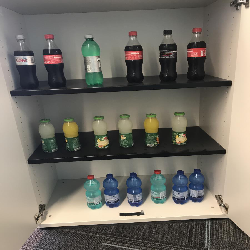

Correctly predicted:


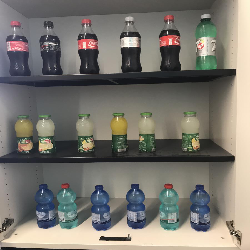

Correctly predicted:


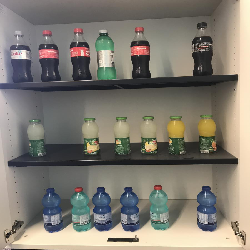

Correctly predicted:


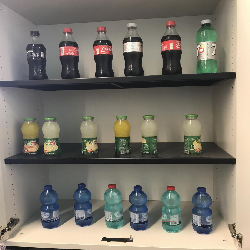

Correctly predicted:


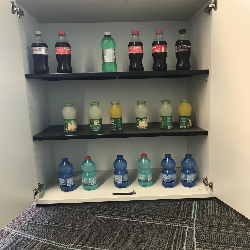

Correctly predicted:


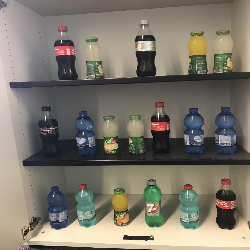

Correctly predicted:


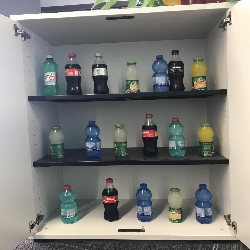

Correctly predicted:


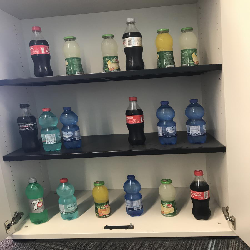

Correctly predicted:


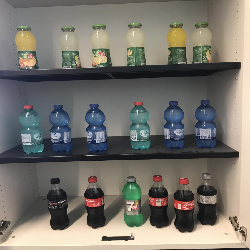

Correctly predicted:


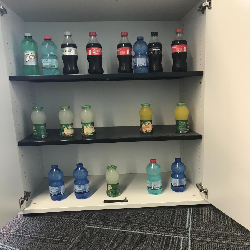

In [30]:
from IPython.core.display import display, HTML

test_valid_dir = test_data_dir + "Compliant/"
test_invalid_dir = test_data_dir + "Non-Compliant/"
test_valid_paths = [test_valid_dir + os.fsdecode(image) for image in os.listdir(os.fsencode(test_valid_dir))]
test_invalid_paths = [test_invalid_dir + os.fsdecode(image) for image in os.listdir(os.fsencode(test_invalid_dir))]
test_img_paths = test_valid_paths + test_invalid_paths

y_true = []
y_pred = []

display(HTML('<h1>Testing Compliant images</h1>'))
for img_path in test_valid_paths:
    y_true.append("Compliant")
    predicted_label = score_img(img_path)
    y_pred.append(predicted_label)
    
    if predicted_label == "Compliant":
        print("Correctly predicted:")
    else:
        print("Incorrectly predicted:")
    
    display(Image.open(img_path).resize((250,250)))
    

display(HTML('<h1>Testing Non-Compliant images</h1>'))
for img_path in test_invalid_paths:
    y_true.append("Non-Compliant")
    predicted_label = score_img(img_path)
    y_pred.append(predicted_label)
    
    if predicted_label == "Non-Compliant":
        print("Correctly predicted:")
    else:
        print("Incorrectly predicted:")
    display(Image.open(img_path).resize((250,250)))

In [31]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred, labels=["Compliant", "Non-Compliant"])
cm

array([[5, 0],
       [0, 5]])

## Clean up
Once you no longer need the web service, you can delete it with a simple API call.

In [ ]:
#service.delete()